In [1]:
import pyForwardFolding as pyFF
import pandas as pd
import yaml
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import jax

In [2]:
data = pd.read_parquet("../../NNMFit_testdata/src/NNMFit_testdata/data/datasets/Toise_ToyTracks/dataframe.parquet")
ana = pyFF.config.analysis_from_config("test.yaml")

In [3]:
lik = pyFF.likelihood.PoissonLikelihood(ana)

In [6]:
model = ana.expectations["det1"].model
be = ana.expectations["det1"]

In [25]:
model_parameters = {
    "powerlaw": {"flux_norm": 1.0, "spectral_index": 2.37},
    "atmo_norm": {"flux_norm": 1.0},
    "snowstorm_escale": {"sys_value": 1.0},
    "snowstorm_esmear": {"sys_value": 1.0},
    "delta_gamma": {"delta_gamma": 0.0}
}

In [26]:
input_variables = {
    "true_energy": jnp.asarray(data.true_e),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.reco_e)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.reco_zenith)),
    "baseline_weight": jnp.asarray(data.fluxless_weight),
    "conv_weight": jnp.asarray(data.weight_honda2006),
    "e_scaling": jnp.asarray(data.e_scaling),
    "e_smearing": jnp.asarray(data.e_smearing),
    "summary_stat": jnp.log10(jnp.asarray(data.reco_e))
}

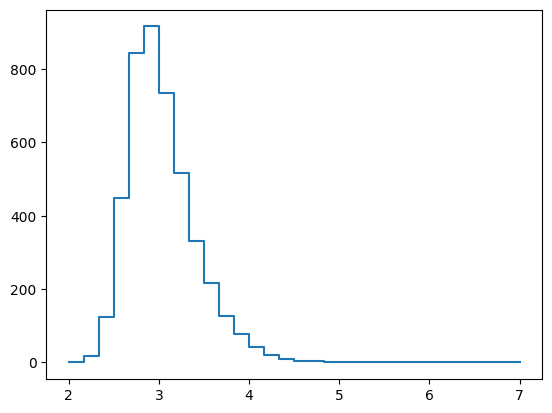

In [27]:
dataset = {"det1": input_variables}
pred = ana.evaluate(dataset, model_parameters)[0]
hsum = pred["det1"].sum(axis=1)
plt.step(be.binning.bin_edges[0], jnp.append(hsum, hsum[-1]))


In [28]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
key = jax.random.PRNGKey(0)
obs = {}
for k, v in hist.items():
    key, subkey = jax.random.split(key)
    obs[k] = jax.random.poisson(subkey, v)
obs = hist # asimov

In [29]:
lh = lik.llh(obs, dataset, model_parameters)
lh_jit = jax.jit(lik.llh)


In [30]:
def eval_for_par(par_val, par_dict):
    par_dict["snowstorm_escale"]["sys_value"] = par_val
    lh = lik.llh(obs, dataset, par_dict)
    return lh

val_grad = jax.jit(jax.value_and_grad(eval_for_par, 0) )


In [31]:
%timeit val_grad(1.0, model_parameters)

834 μs ± 23.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


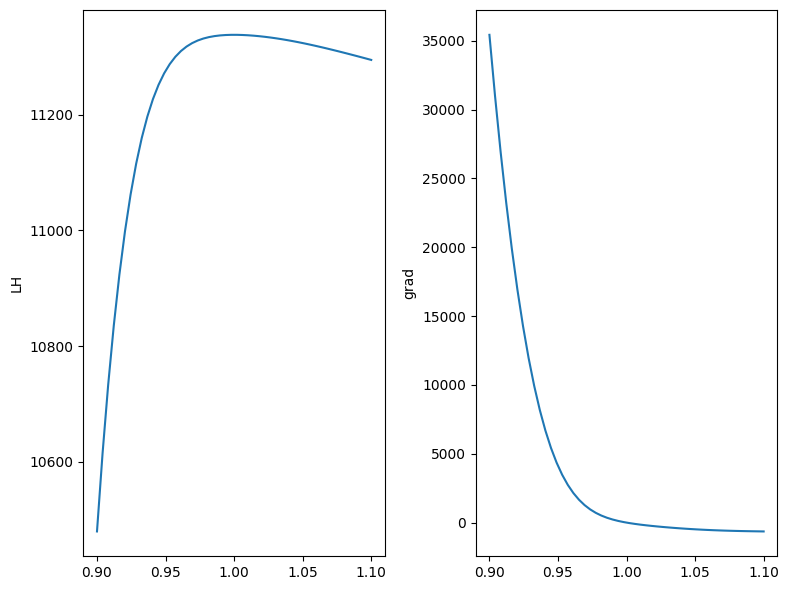

In [32]:
scan_vals = jnp.linspace(0.9, 1.1, 50)
lhs, grads = jax.vmap(val_grad, in_axes=(0, None))(scan_vals, model_parameters)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.plot(scan_vals, lhs)
ax1.set_ylabel("LH")
ax2.plot(scan_vals, grads)
ax2.set_ylabel("grad")
plt.tight_layout()